In [36]:
import numpy as np
import csv
import visuals as vs
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
import time as time
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy import ndimage
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline



def process_data(path):
    mydata = []
    with open(path) as f:
        head = True
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            if head:
                head = False
            elif float(row[-2])>0:
                mydata.append([float(row[6]),float(row[7]),float(row[-1])/float(row[-2])])
    return mydata



def showdata(X):
    # #############################################################################
    # Compute clustering
    print("Compute unstructured hierarchical clustering...")
    
    st = time.time()
    ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
    elapsed_time = time.time() - st
    label = ward.labels_
    print("Elapsed time: %.2fs" % elapsed_time)
    print("Number of points: %i" % label.size)
    
    # #############################################################################
    # Plot result
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.view_init(7, -80)
    for l in np.unique(label):
        ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
                   color=plt.cm.jet(np.float(l) / np.max(label + 1)),
                   s=20, edgecolor='k')
    plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)
    
    # #############################################################################
    # Define the structure A of the data. Here a 10 nearest neighbors
    from sklearn.neighbors import kneighbors_graph
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    
    # #############################################################################
    # Compute clustering
    print("Compute structured hierarchical clustering...")
    st = time.time()
    ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity,
                                   linkage='ward').fit(X)
    elapsed_time = time.time() - st
    label = ward.labels_
    print("Elapsed time: %.2fs" % elapsed_time)
    print("Number of points: %i" % label.size)
    
    # #############################################################################
    # Plot result
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.view_init(7, -80)
    for l in np.unique(label):
        ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
                   color=plt.cm.jet(float(l) / np.max(label + 1)),
                   s=20, edgecolor='k')
    plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)
    
    plt.show()

def hca(X, met):
 #   path = sys.argv[1]
    #path = 'data/orderWithCustomer.csv'
    #X, y = read_csv(path)

    # find distance matrix
    d = distance_matrix(X, X)
    for link in ('ward', 'average', 'complete'):
        clustering = AgglomerativeClustering(linkage=link, n_clusters=10).fit(d)
        st = time.time()
        label = clustering.labels_
        elapsed_time = time.time() - st

    # Draw the clustering heatmap based on different methods
    sns.set(color_codes=True)
    g1 = sns.clustermap(X, method='ward', metric=met, figsize=(5, 8))
    g2 = sns.clustermap(X, method='average', metric=met, figsize=(5, 8))
    g3 = sns.clustermap(X, method='complete', metric=met, figsize=(5, 8))

    # Draw the dendrogram of the clustering based on different methods
    plt.figure()
    plt.title('Hierarchical Clustering Dendrogram (ward)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    Z = linkage(X, 'ward')
    dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=8.,
    )
    plt.figure()
    plt.title('Hierarchical Clustering Dendrogram (average)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    Z = linkage(X, 'average')
    dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=8.,
    )
    plt.figure()
    plt.title('Hierarchical Clustering Dendrogram (complete)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    Z = linkage(X, 'complete')
    dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=8.,
    )
    plt.show()

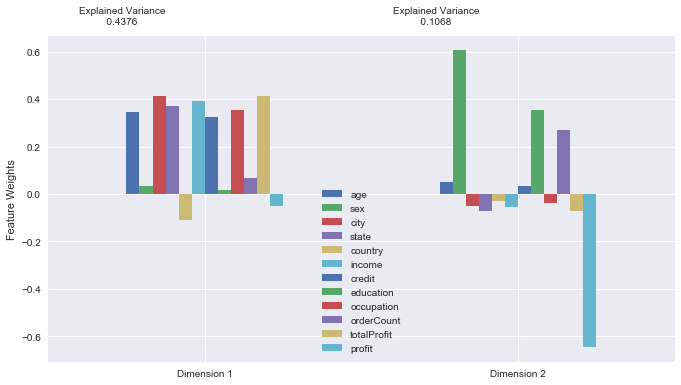

In [37]:

df = pd.read_csv('./data/orderWithProfit.csv', header=0)
# filtered_df = df[df['orderdate'].isnull()]
df = df.dropna()
df["orderDate"] = df["orderDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["takenDate"] = df["takenDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["shipDate"] = df["shipDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["transitDuration"] = (df["shipDate"]-df["takenDate"])/ np.timedelta64(1, 's')
df["fulfillDuration"] = (df["shipDate"]-df["orderDate"])/ np.timedelta64(1, 's')

df["amount"] = df["red"]+df["blue"]+df["yellow"]+df["black"]+df["white"]

dic = {}

# Combine with customer info
df_tmp = pd.read_csv('./data/orderWithCustomer.csv', header=0)
df = pd.merge(df, df_tmp, how='inner', left_on="customer", right_on="name",suffixes=('_x', '_y'),)

for key in ["customer", "name","age", "sex", "city", "state", "country",\
                 "income", "credit","education", "occupation","orderCount","totalProfit"]:
    dic[key] = {}
    ## Add Customer ID (Integer number)
    id = 1
    for _,name in df[[key]].drop_duplicates()[key].iteritems():
        dic[key][name] = id # id starts from 0
        id = id+1
    df[key] = df[key].apply(lambda x: dic[key][x])
    
X = {}
index = {}
target = {"users":"profit","order":"profit","duration":"transitDuration","comples":"profit"}

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
index["users"]=["age","sex", "city", "state","country","income","credit","education","occupation","orderCount","totalProfit","profit"]


scaler = StandardScaler()

X["users"] = scaler.fit_transform(df[index["users"]].values)
pca = PCA(n_components=2)
X["users"] = pca.fit_transform(X["users"])

pca_results = vs.pca_results(df[index["users"]], pca)

## Data preparation

### Raw data

In [38]:
data = np.array(X["users"])
#print (data)


### Standarize data

In [39]:
data_scaled = preprocessing.scale(data)

## HCA (Euclidean distance)

### HCA with raw data

C:\Program Files\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\Program Files\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:410: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


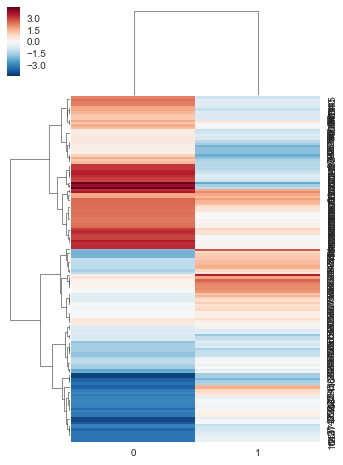

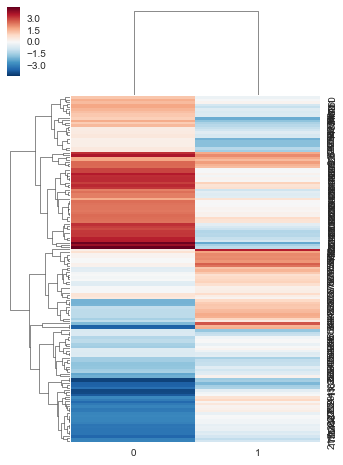

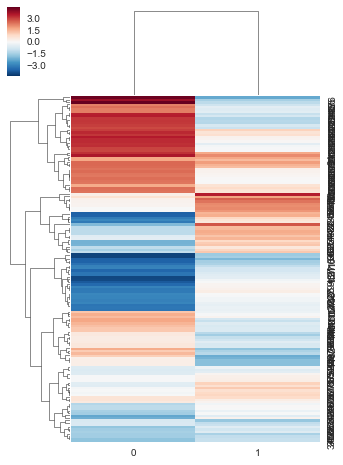

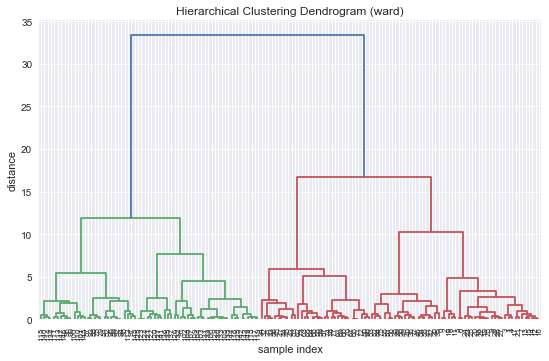

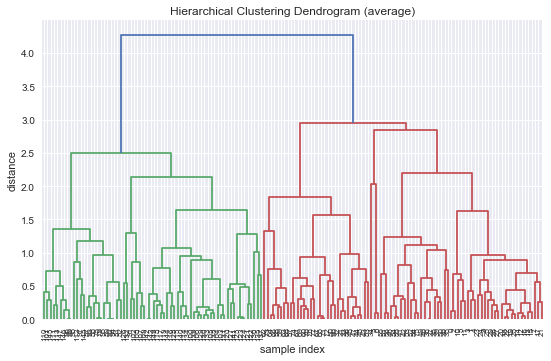

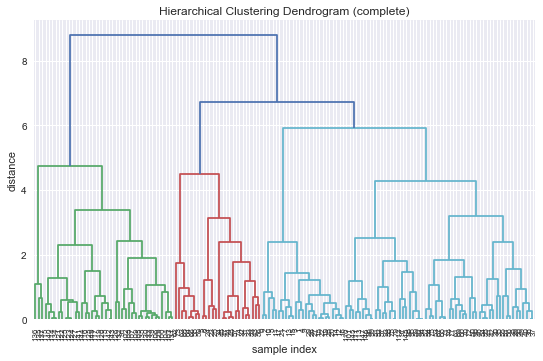

In [40]:
#showdata(data)
hca(data,'euclidean')

### HCA with standarized data

C:\Program Files\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\Program Files\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:410: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


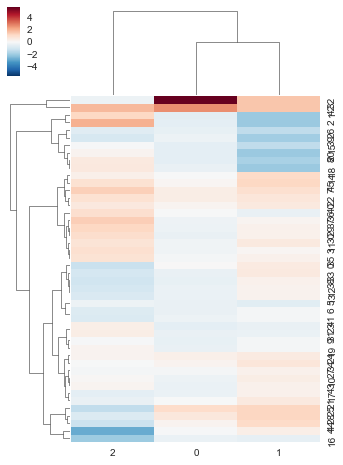

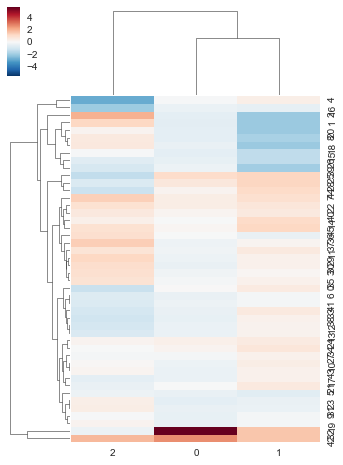

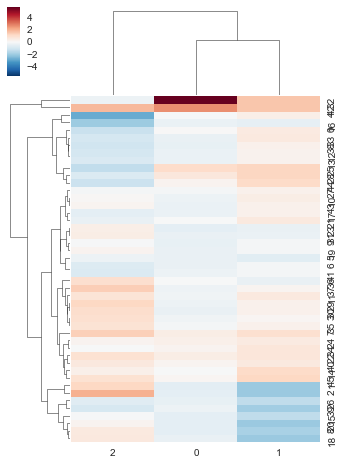

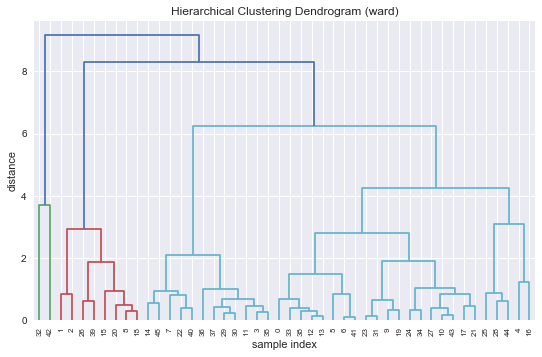

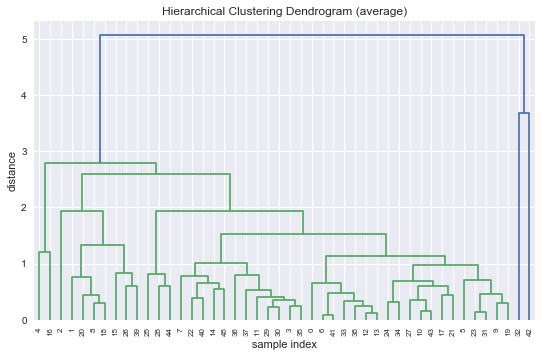

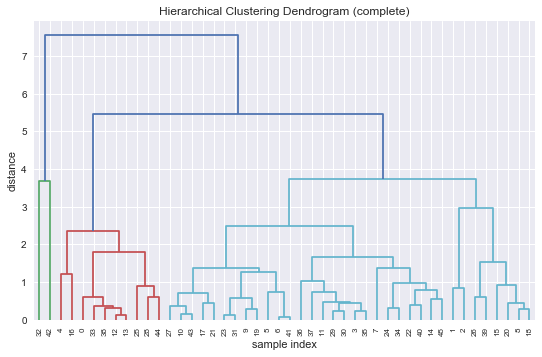

In [41]:
#showdata(X_scaled)
hca(X_scaled,'euclidean')

## HCA (correlation-based)

### HCA with raw data

C:\Program Files\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\Program Files\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:410: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


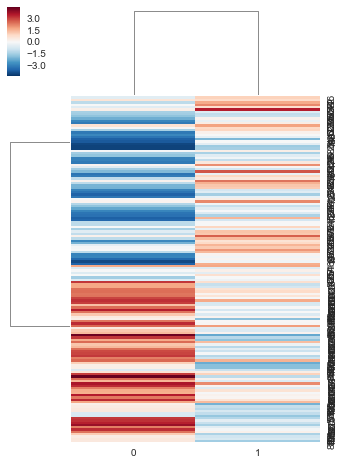

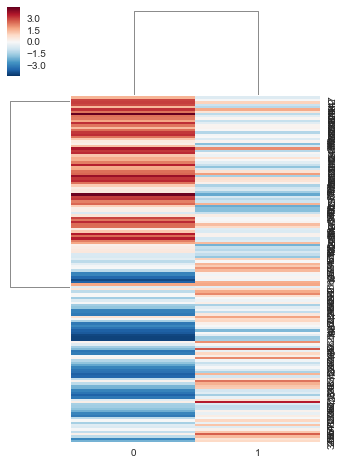

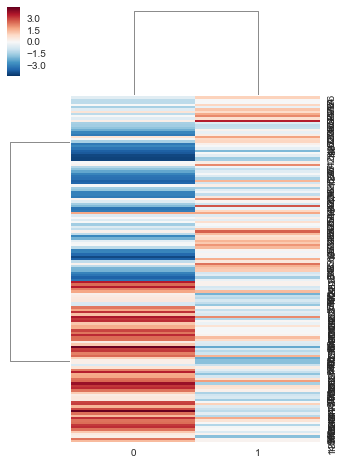

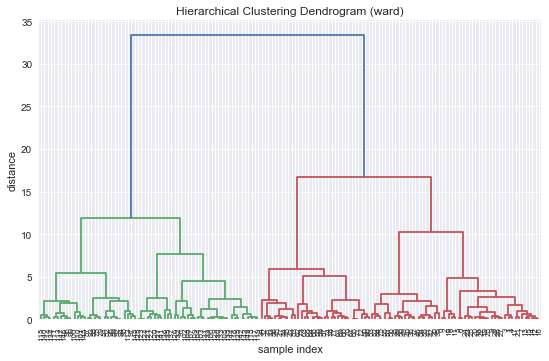

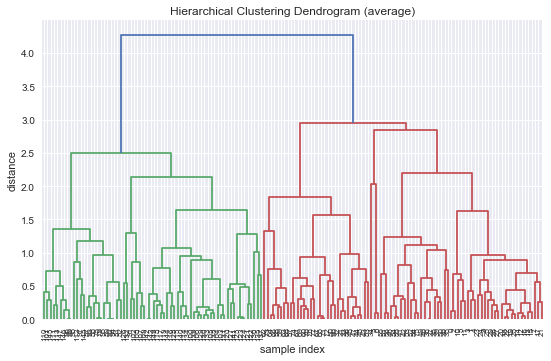

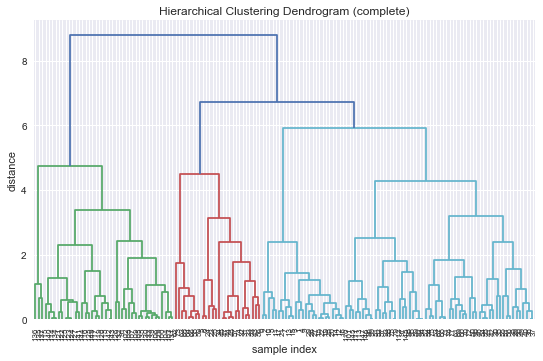

In [42]:
hca(data,'correlation')

### HCA with standarized data

C:\Program Files\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\Program Files\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:410: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


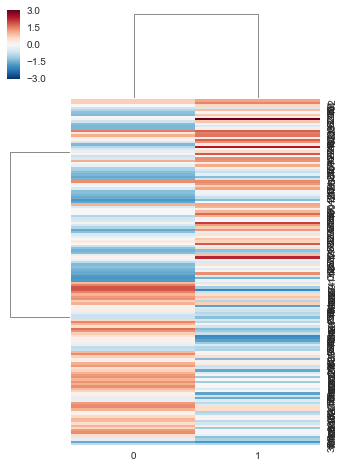

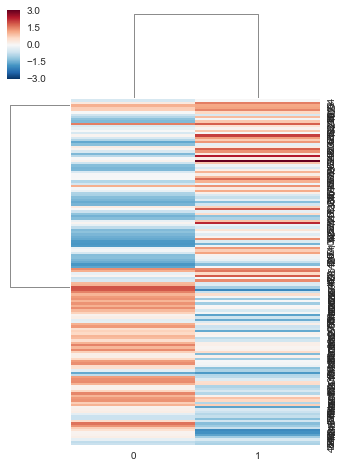

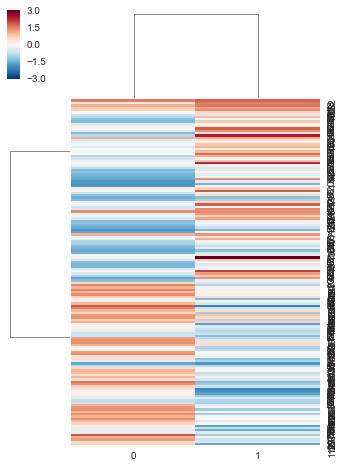

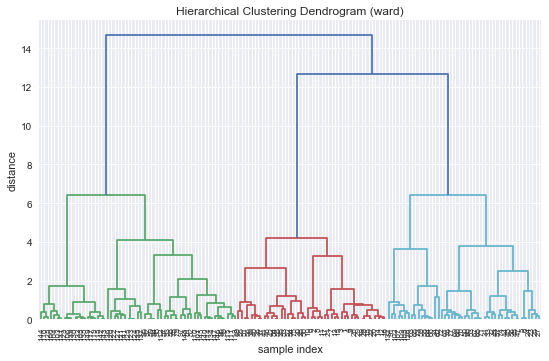

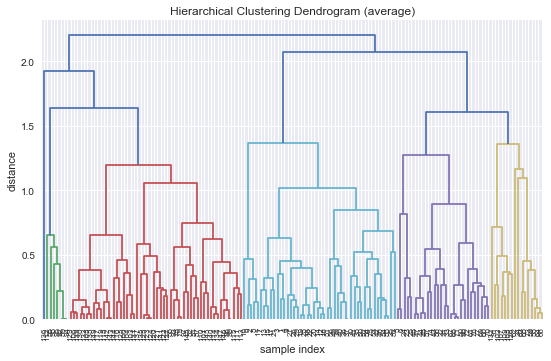

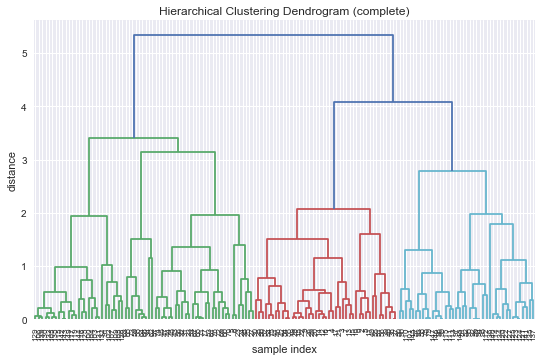

In [43]:
hca(data_scaled,'correlation')

## Comparison of graphs
2.1: Euclidean distance HCA with raw data

2.2: Euclidean distance HCA with standarized data

3.1: Correlation-based HCA with raw data

3.2: Correlation-based HCA with standarized data 